In [1]:
import re
import numpy as np
import pandas as pd
import nltk
import unicodedata
import csv
import itertools
from tqdm.notebook import trange, tqdm
from nltk import word_tokenize, pos_tag, corpus
from nltk.stem import WordNetLemmatizer
from collections import defaultdict, Counter
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
# Read in the datasets
df_directions = pd.read_excel('/Users/nessyliu/Desktop/RA/AllRecipes_Directions_2019-11-26.xlsx')
df = pd.read_csv('/Users/nessyliu/Desktop/RA/AllReviews_26thNov2019.csv')
df_ingredients_raw = pd.read_csv('/Users/nessyliu/Desktop/RA/part_2/Ingredients.csv')
df_cluster = pd.read_excel('/Users/nessyliu/Desktop/RA/part_2/Cluster_names.xlsx')

df_ingre_clean = pd.read_csv('/Users/nessyliu/Desktop/RA/part_2/ingredients_after_text_cleaning.csv')
df_mod = pd.read_excel('/Users/nessyliu/Desktop/RA/part_2/Final_clusters_mod.xlsx')

In [3]:
full_directions_list = []
recipe_id_list = list(set(df_directions.recipe_id.tolist()))
for recipe_id in recipe_id_list:
    full_dir_this_recipe = ' '.join(df_directions.loc[df_directions['recipe_id']==recipe_id, 'directions_step_text'])
    full_directions_list.append(full_dir_this_recipe)
dict_recipe_direction = dict(zip(recipe_id_list, full_directions_list))

In [4]:
# list of cluster names with spaces (e.g. apple juice) sorted by number of words in each name, 
# e.g. "apple juice" should appear before "juice"
cluster_name_orig_list = df_cluster.cluster_name.tolist()
cluster_name_orig_list.sort(key=lambda x: len(x.split()), reverse=True)

# create dict to map recipe_id to ingredient_ids
df_ingredients = df_ingredients_raw.groupby('recipe_id')['ingredient_id'].apply(list).reset_index(name ='ingredients')
dict_recipe_ingredients = dict(zip(df_ingredients.recipe_id, df_ingredients.ingredients))

# create dict to map ingredient_id to cluster_name
df_cluster = df_cluster.replace(' ', '_', regex=True)
dict_ingredient_clustername = dict(zip(df_cluster.ingredient_id, df_cluster.cluster_name))

In [5]:
# lemmatization dict
lemma_list = pd.read_csv('/Users/nessyliu/Desktop/RA/lemma_list.csv')
lemma_dict = lemma_list.set_index('word_list').to_dict()['lemma_list']

def lemmatization(text):
    
    text = text.lower()
    
    text = text.replace('sugar substitute', 'sweetener').replace('french fry','frenchfry')
    
    text = text.replace('lowfat','low fat').replace('nonfat','non fat').replace('glutenfree','gluten free').replace('corn flakes','cornflakes')
    
    text = text.replace('coconutmilk',
                        'coconut milk').replace('almondmilk',
                                                'almond milk').replace('crab meat',
                                                                       'crabmeat').replace('starfruit', 
                                                                                           'star fruit').replace('breadcrumb', 'bread crumb')
    
    # use the custom lemma dict first
    text = " ".join(str(lemma_dict.get(word, word)) for word in text.split())
    
    # then use the WordNetLemmatizer from nltk
    wnl = WordNetLemmatizer()
    # lemmatize each word based on its pos tagging
    text_after = " ".join([wnl.lemmatize(i,j[0]) if j[0] in ['a','n','v'] else wnl.lemmatize(i) for i,j in pos_tag(word_tokenize(text))])    
    return text_after

In [6]:
unigram_exclude_list = ['purpose','extra', 'whole', 'frying', 'cut', 
                        'sun', 'baby', 'five', 'star', 'non', 'dash', 'style',
                        'white', 'green', 'black', 'red', 'pink', 'yellow', 'brown', 'golden', 'blue', 
                        'color', 'colored', 'half', 'alternative',
                        'ground', 'sea', 'part', 'baked', 'raw', 'new', 'active',
                        'italian', 'dark', 'light', 'fresh', 'sweet', 'candied',
                        'dried', 'dry', 'heavy', 'condensed', 'firm', 'soft', 'free', 
                        'mixed', 'flavored', 'evaporated', 'peeled', 'pickled','cooked','chopped', 'broken',
                        'hot', 'self', 'rising', 'split', 'cooking', 'stewed',
                        'de', 'dr']
unigram_exclude_list += corpus.stopwords.words('english')

ngram_exclude_list = ['all_purpose', 'purpose_flour', 'free_all']

ngram_not_start_end = ['for', 'of', 'and', 'with', 'in']

In [7]:
# create dict for appearance times for each cluster name
dict_cluster_count = defaultdict(int)

In [8]:
valid_recipe_id_list = []
perfect_match_list = []
partial_match_list = []
no_match_list = []
recipe_list = []
direction_list = []
lemmatized_direction_list = []

num_ingredient_list = []
num_perfect_match_list = []
num_partial_match_list = []
num_no_match_list = []

count_invalid = 0
for recipe_id in tqdm(recipe_id_list):
    
    # list of ingre that appeared exactly the same in the direction
    perfect_match_this_recipe = []
    # list of ingre that matched shorter form in the direction
    partial_match_this_recipe = []
    # list fo ingre that are not matched
    no_match_this_recipe = []
    
    # count number of ingredients
    num_perfect_match_this_recipe = 0
    num_partial_match_this_recipe = 0
    num_no_match_this_recipe = 0

    # get the ingredients of this recipe id
    try:
        recipe = [dict_ingredient_clustername[ingre_id] for ingre_id in dict_recipe_ingredients[recipe_id]]
        valid_recipe_id_list.append(recipe_id)
        
        recipe.sort(key=lambda x: len(x.split('_')), reverse=True)
        
        # get the direction of this recipe id
        direction = dict_recipe_direction[recipe_id]
        lemmatized_direction = lemmatization(dict_recipe_direction[recipe_id])
        # map each ingredient to the words in the direction
        for ingre in recipe:
            dict_cluster_count[ingre] += 1
            ingre_tokens = ingre.split('_')
            ingre_original = ' '.join(ingre_tokens)
            if ingre_original in direction or ingre_original in lemmatized_direction:
                perfect_match_this_recipe.append(ingre)
                num_perfect_match_this_recipe += 1
            else:
                partial_match_this_ingre = []
                if len(ingre_tokens) > 1:
                    n = len(ingre_tokens)-1
                    while n > 0: # length of the short form
                        for i in range(0,len(ingre_tokens)-n+1): # start index in the full cluster name
                            short_form = ' '.join(ingre_tokens[i:i+n])
                            if short_form in direction or short_form in lemmatized_direction:
                                # the short form is a map to the ingre
                                # don't break the loop if matched, cuz 'oil for frying' may end up matched 'for frying' and break
                                # but ignore subsequence part, e.g. if 'firm tofu' is matched, ignore 'firm' & 'tofu'
                                if not any(short_form in existing_short_form for existing_short_form in partial_match_this_ingre):
                                    if n > 1: # if the short form >=2 words
                                        if short_form.replace(' ','_') not in ngram_exclude_list\
                                            and ingre_tokens[i] not in ngram_not_start_end \
                                            and ingre_tokens[i+n-1] not in ngram_not_start_end:
                                                # if the short form not in ngram_exclude_list
                                                # and the short form does not start or end with words in ngram_not_start_end list
                                                partial_match_this_ingre.append(short_form.replace(' ','_'))
                                    else: # if the short form is unigram
                                        if short_form not in unigram_exclude_list:
                                            partial_match_this_ingre.append(short_form)

                        n -= 1
                if len(partial_match_this_ingre) == 0:
                    no_match_this_recipe.append(ingre)
                    num_no_match_this_recipe += 1
                else:
                    partial_match_this_recipe.append([ingre, partial_match_this_ingre])
                    num_partial_match_this_recipe += 1

        recipe_list.append(recipe)
        direction_list.append(direction)
        lemmatized_direction_list.append(lemmatized_direction)
        perfect_match_list.append(perfect_match_this_recipe)
        partial_match_list.append(partial_match_this_recipe)
        no_match_list.append(no_match_this_recipe)
        num_perfect_match_list.append(num_perfect_match_this_recipe)
        num_partial_match_list.append(num_partial_match_this_recipe)
        num_no_match_list.append(num_no_match_this_recipe)
        num_ingredient_list.append(len(recipe))
    
    
    except:
        count_invalid += 1
        continue

matched_df = pd.DataFrame({
    'recipe_id': valid_recipe_id_list, 
    'recipe': recipe_list,
    'direction': direction_list,
    'lemma_direction': lemmatized_direction_list,
    'perfect_match': perfect_match_list,
    'partial_match': partial_match_list,
    'no_match': no_match_list,
    'num_ingredient': num_ingredient_list,
    'num_perfect_match': num_perfect_match_list,
    'num_partial_match': num_partial_match_list,
    'num_no_match': num_no_match_list
})

In [9]:
# print(matched_df.shape)
matched_df.to_csv('/Users/nessyliu/Desktop/RA/part_2/result/matched_directions_orgin_w5.csv')

In [10]:
# # test the 1-gram to (n-1)-gram shorter forms
# ingre_tokens = ['fresh','white','chocolate','chips']

# n = len(ingre_tokens)-1
# while n > 0:
#     for i in range(0,len(ingre_tokens)-n+1):
#         short_form = ' '.join(ingre_tokens[i:i+n])
#         print(short_form)
#     n = n-1

## Count of ingredients not matched in all recipe directions

In [11]:
no_match_list_flat = list(itertools.chain.from_iterable(no_match_list))
count_no_match = Counter(no_match_list_flat)
count_no_match = count_no_match.most_common()
len(count_no_match) # ingre at least not matched in 1 recipe

762

## Check Label2 in Final_clusters_mod for synonyms

In [36]:
no_label2 = []

# To find synonyms:
# For each missing ingredient, check the label2 in Final_clusters_mod.csv
for (missing_ingre, missing_count) in count_no_match:
    missing_ingre_unigrams = missing_ingre.split('_')
    all_label2 = ' '.join(df_mod.loc[df_mod['cluster_name'] == ' '.join(missing_ingre_unigrams),'label2'])
    unigrams = all_label2.split(' ')
    count_unigrams = Counter(unigrams).most_common()
    if len(count_unigrams)>0:
        possible_names = [unigram for (unigram, count) in count_unigrams if unigram \
                          not in unigram_exclude_list+missing_ingre_unigrams+['']\
                          and pos_tag([unigram])[0][1]=='NN']
    if len(possible_names)>0:
        if missing_count > 40:
            print(missing_ingre, missing_count)
            print(possible_names)
    else:
        no_label2.append(missing_ingre)

half_and_half 734
['fat']
salt 662
['sodium']
garbanzo_bean 223
['chickpea', 'liquid', 'gravy', 'crumb', 'bengal', 'gram']
green_onion 202
['scallion']
ground_cinnamon 195
['mccormick', 'ceylon']
margarine 187
['vegan', 'spread', 'fat', 'butter', 'soy', 'oil', 'corn', 'dairy', 'vegetable']
water 186
['orange', 'flower', 'spring']
butter 182
['sunbutter', 'variety', 'garlic', 'land']
pecan 181
['decoration', 'extract']
graham_cracker 160
['crust', 'chocolate', 'pie', 'crumb', 'mini', 'cinnamon', 'fat', 'deep', 'dish', 'cooky', 'bear', 'snack', 'honey', 'maid']
pie_crust 143
['shell', 'tart', 'pastry', 'deep', 'dish', 'shortbread', 'mix', 'wheat', 'chocolate', 'sandwich', 'cookie', 'pillsbury', 'box', 'mini', 'phyllo', 'shortcake', 'recipe', 'ball', 'dough']
ground_nutmeg 124
['mccormick']
egg 123
["eggland's", 'strip']
vanilla_extract 120
['imitation', 'mccormick', 'pure']
crabmeat 109
['crab', 'imitation', 'king', 'leg', 'thawed', 'alaskan', 'shell', 'snow', 'cluster']
ground_beef 93
[

In [33]:
#no_label2 # does not have possible unigram name in label2

## Ingredients missing pattern

In [14]:
# missing (no match) pattern
all_no_match_unique = set(no_match_list_flat)

In [15]:
matched_df_missing = matched_df.loc[:,['recipe_id', 'no_match']]

no_match_span_df = pd.concat([pd.Series(row['recipe_id'], row['no_match']) for _, row in tqdm(matched_df_missing.iterrows())]).reset_index()

In [16]:
no_match_span_df.columns = ['missing_ingredient', 'recipe_id']
missing_matrix = pd.pivot_table(no_match_span_df, values='missing_ingredient', index=['recipe_id'], columns=['missing_ingredient'], aggfunc=lambda x: len(x))

missing_matrix = missing_matrix.fillna(0)

missing_matrix.shape # row is each recipe, col is each (missing) ingre

# missing_matrix.insert(loc=0, column='recipe_id', value=missing_matrix.index)

(7824, 762)

There are 57709 recipes in total.
There are 7824 recipes with at least 1 ingredient not matched.
There are 762 unique ingredients not matched in at least 1 recipe out of 57709 recipes.
There are 675 unique ingredients not matched in <= 20 % of its appearances.
There are 87 unique ingredients not matched in > 20 % of its appearances.


Text(0.5, 0, 'Not matched in % of its appearances')

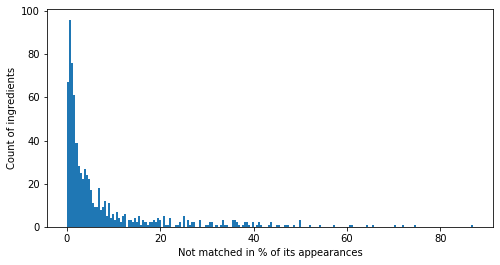

In [17]:
missing_in_num_recipes = [(col, col_sum) for col, col_sum in missing_matrix.sum().iteritems()]
missing_pct = [(col, (col_sum / dict_cluster_count[col])*100) for (col, col_sum) in missing_in_num_recipes]

thres_pct = 20
print('There are', len(no_match_list), 'recipes in total.')
print('There are', len(missing_matrix), 'recipes with at least 1 ingredient not matched.')
print('There are', len(all_no_match_unique), 'unique ingredients not matched in at least 1 recipe out of',len(no_match_list),'recipes.')
print('There are', len([col for col, pct in missing_pct if pct <= thres_pct]), 'unique ingredients not matched in <=', thres_pct,'% of its appearances.')
print('There are', len(all_no_match_unique) - len([col for col, pct in missing_pct if pct <= thres_pct]), 'unique ingredients not matched in >', thres_pct,'% of its appearances.')

plt.rcParams['figure.figsize'] = [8, 4]

plt.hist([pct for col, pct in missing_pct], density=False, bins=200)
plt.ylabel('Count of ingredients')
plt.xlabel('Not matched in % of its appearances') ### change to pct, not matched / all it appears， sort

In [18]:
# [col for col, pct in missing_pct if pct > thres_pct]

In [19]:
# drop the ingredients that only not matched in <= thres recipes
# drop the recipes that contain more than 1 missing ingredient now

missing_matrix_drop = missing_matrix.copy()

missing_matrix_drop.drop([col for col, pct in missing_pct if pct <= thres_pct], axis=1, inplace=True)
missing_matrix_drop = missing_matrix_drop.loc[(missing_matrix_drop.sum(axis=1) > 1),:]
missing_matrix_drop.shape

(102, 87)

In [20]:
corr_matrix = missing_matrix_drop.corr()

In [21]:
# plt.rcParams['figure.figsize'] = [15, 15]
# sn.heatmap(corr_matrix, annot=True, cmap="Blues")
# plt.show()

In [34]:
corr_matrix_lower = corr_matrix.copy()

corr_matrix_lower.loc[:,:] =  np.tril(corr_matrix_lower, k=-1) # borrowed from Karl D's answer

already_in = set()
missing_ingredients_clusters = []
for col in corr_matrix_lower:
    high_corr = corr_matrix_lower[col][corr_matrix_lower[col] > 0.02].index.tolist()
    if high_corr and col not in already_in:
        already_in.update(set(high_corr))
        high_corr.append(col)
        missing_ingredients_clusters.append(high_corr)

In [23]:
# check the direction texts missing the above clusters of ingredients

# no_match_df = matched_df.loc[matched_df['num_no_match']>0,:]

# check_list = no_match_df.loc[no_match_df.no_match.map(lambda x: 'baking_soda' in x), 'direction']
# for direction in check_list:
#     print(direction)

## Create dict containing all the mappings from above findings

In [91]:
'''
Create a dict for cluster name mapping

key: cluster name
value: dict{'short': all appeared short forms (only for multi-gram cluster names), 
            'parent': parent names, 
            'child': child names,
            'synonym': synonyms}
'''

all_short_forms = []
dict_ingre_mapping = defaultdict(lambda: defaultdict(list))
for partial_match_this_recipe in partial_match_list:
    for partial_match_this_ingre in partial_match_this_recipe:
        ingre = partial_match_this_ingre[0]
        
        # add "dry ingredient" as parent term for ingredients with "dried"
        if ('dried' in ingre) and ('dry_ingredient' not in dict_ingre_mapping[ingre]['parent']):
            dict_ingre_mapping[ingre]['parent'].append('dry_ingredient')
        
        # add parent names for ingredients with "broth"
        if ('broth' in ingre) and ('stock' not in dict_ingre_mapping[ingre]['parent']):
            dict_ingre_mapping[ingre]['parent'] += ['stock','consomme','soup']
        short_forms = partial_match_this_ingre[1]
        
        # add parent names for ingredients with "preserve"
        if ('jam' in ingre) and ('preserve' not in dict_ingre_mapping[ingre]['parent']):
            dict_ingre_mapping[ingre]['parent'] += ['preserve']
        short_forms = partial_match_this_ingre[1]
        
        # add in all short forms to the dict
        for short_form in short_forms:
            if short_form not in dict_ingre_mapping[ingre]['short']:
                dict_ingre_mapping[ingre]['short'].append(short_form)
                
                
#### add in parent terms
# nut
nut_cluster = ['walnut', 'pecan', 'almond']
for ingre in nut_cluster:
    dict_ingre_mapping[ingre]['parent'].append('nut')

# spice
spice_cluster = ['ground_cinnamon', 'ground_nutmeg']
for ingre in spice_cluster:
    dict_ingre_mapping[ingre]['parent'].append('spice')

# meat
meat_cluster = ['ground_beef', 'pork_sausage']
for ingre in meat_cluster:
    dict_ingre_mapping[ingre]['parent'].append('meat')
    
# roast
roast_cluster = ['beef_chuck', 'beef_tenderloin']
for ingre in roast_cluster:
    dict_ingre_mapping[ingre]['parent'].append('roast')

# steak
steak_cluster = ['beef', 'beef_sirloin', 'pork']
for ingre in steak_cluster:
    dict_ingre_mapping[ingre]['parent'].append('steak')
    
# berry
berry_cluster = ['blackberry','blueberry']
for ingre in berry_cluster:
    dict_ingre_mapping[ingre]['parent'].append('berry')


dict_ingre_mapping['rose']['parent'].append('petal')
dict_ingre_mapping['graham_cracker']['parent'] += ['crust', 'crumb']
dict_ingre_mapping['ground_beef']['parent'] += ['meatloaf', 'patty']
dict_ingre_mapping['sirloin']['parent'].append('beef')
dict_ingre_mapping['beef']['parent'] += ['rib', 'tamale']
dict_ingre_mapping['cod']['parent'] += ['fish', 'fillet']



#### add in child terms
dict_ingre_mapping['topping']['child'].append('spice')
dict_ingre_mapping['potato']['child'].append('frenchfry')
dict_ingre_mapping["pig's_part"]['child'] += ['pork', 'liver', 'ear', 'tail', 'foot', 'pig', 'jowl', 'stomach', 'cheek']
dict_ingre_mapping["liqueur"]['child'] += ['daiquiri','cocktail', 'chartreuse', 'cachaca', 'mezcal']
dict_ingre_mapping["bean"]['child'] += ['soybean']
dict_ingre_mapping["other_fish"]['child'] += ['bonito', 'fillet', 'milkfish', 'herring', 'mackerel', 
                                              'sardine', 'bluefish', 'perch', 'monkfish', 'bass', 
                                             'hake', 'amberjack', 'butterfish', 'pollock', 'rockfish', 
                                              'pompano', 'milkfish', 'char', 'smelt', 'mullet', 'saury']


#### add in synonyms
dict_ingre_mapping['garbanzo_bean']['synonym'].append('chickpea')
dict_ingre_mapping['green_onion']['synonym'].append('scallion')
dict_ingre_mapping['espresso']['synonym'].append('coffee_bean')
# dict_ingre_mapping['margarine']['synonym'].append('butter')
# dict_ingre_mapping['butter']['synonym'].append('margarine')
dict_ingre_mapping['crabmeat']['synonym'].append('crab')
dict_ingre_mapping['green_chile_pepper']['synonym'].append('chili')
dict_ingre_mapping['spaghetti']['synonym'] += ['spaghettini', 'pasta']
dict_ingre_mapping['macaroni']['synonym'] += ['pasta']
dict_ingre_mapping['pasta']['synonym'] += ['rotelle', 'cavatappi']
dict_ingre_mapping['bread_crumb']['synonym'] += ['panko']
dict_ingre_mapping['raisin']['synonym'] += ['sultana']
dict_ingre_mapping['adobo_sauce']['synonym'] += ['chipotle']
dict_ingre_mapping['sweetener']['synonym'] += ['fructose']
dict_ingre_mapping['bread']['synonym'] += ['loaf', 'toast', 'challah', 'farl']
dict_ingre_mapping['cornflakes_cereal']['synonym'] += ['cornflake']
dict_ingre_mapping['parsley']['synonym'] += ['chervil']
dict_ingre_mapping['cod']['synonym'] += ['lingcod']
dict_ingre_mapping['soy_sauce']['synonym'] += ['tamari']
dict_ingre_mapping['orange_jam']['synonym'] += ['marmalade']
dict_ingre_mapping['pie_crust']['synonym'] += ['shell']
dict_ingre_mapping['green_tea']['synonym'] += ['matcha']
dict_ingre_mapping['beef_tenderloin']['synonym'] += ['mignon_filet', 'filet', 'mignon', 'steak']
dict_ingre_mapping['beer']['synonym'] += ['stout', 'ale']
dict_ingre_mapping['buttermilk']['synonym'] += ['sour_milk']
dict_ingre_mapping['club_soda']['synonym'] += ['carbonated_water', 'seltzer', 'sparkling_water']
dict_ingre_mapping['cooky']['synonym'] += ['biscuit']
dict_ingre_mapping['nori']['synonym'] += ['seaweed']

In [25]:
# Print the dict
# for key in dict_ingre_mapping:
#     print('\n',key)
#     print(dict_ingre_mapping[key])

# Save the dict

# import csv

# with open('/Users/nessyliu/Desktop/RA/part_2/result/dict_ingre_mapping_w5.csv', 'w') as f:
#     for key in dict_ingre_mapping.keys():
#         f.write("%s,%s\n"%(key,dict_ingre_mapping[key]))

In [92]:
from ast import literal_eval

matched_df2 = pd.read_csv('/Users/nessyliu/Desktop/RA/part_2/result/matched_directions_orgin_w5.csv')

#print(matched_df2.dtypes)
dict_match_list = []
num_dict_match_list = []
num_ignore_list = []
new_no_match_list = []

for i in tqdm(range(0,len(matched_df2))):
    row = matched_df2.iloc[i,:]
    dict_match_this_recipe = [] # match of missing ingredients in this recipe by using the dict
    num_dict_match_this_recipe = 0
    num_ignore = 0
    no_match_this_recipe = literal_eval(row.no_match)
    if row.num_no_match > 0:
        direction = row.direction + ' ' + row.lemma_direction
        for missing_ingre in no_match_this_recipe:
            if missing_ingre in ['salt', 'water']:
                num_ignore += 1
            else:
                dict_match_this_ingre = []
                parent = dict_ingre_mapping[missing_ingre]['parent']
                short = dict_ingre_mapping[missing_ingre]['short']
                child = dict_ingre_mapping[missing_ingre]['child']
                synonym = dict_ingre_mapping[missing_ingre]['synonym']
                all_possible_names = synonym + parent + short + child
                for name in all_possible_names:
                    if name.replace('_', ' ') in direction: # if there is a match between the missing ingre and name in the dict
                        dict_match_this_ingre.append(name)

                if len(dict_match_this_ingre) > 0:
                    dict_match_this_recipe.append([missing_ingre, dict_match_this_ingre])
                    num_dict_match_this_recipe += 1
                    # if this ingre is matched using dict, remove it from no_match column, and modify the num_no_match
                    no_match_this_recipe.remove(missing_ingre)
                    matched_df2.loc[i,'num_no_match'] -= 1

    dict_match_list.append(dict_match_this_recipe)
    num_dict_match_list.append(num_dict_match_this_recipe)
    num_ignore_list.append(num_ignore)
    new_no_match_list.append(no_match_this_recipe)

    
matched_df2 = matched_df2.drop(['no_match'], axis = 1)
matched_df2.insert(7, 'dict_match', dict_match_list)
matched_df2.insert(8, 'no_match', new_no_match_list)
matched_df2.insert(12, 'num_dict_match', num_dict_match_list)
matched_df2.insert(14, 'num_ignore', num_ignore_list)

In [93]:
matched_df2.to_csv('/Users/nessyliu/Desktop/RA/part_2/result/matched_directions_w5.csv')

In [94]:
print("Number of ingredients in all recipes:")
print(sum(matched_df.num_ingredient))
print("Number of missing ingredients after perfect match:")
print(sum(matched_df.num_ingredient) - sum(matched_df.num_perfect_match))
print("Number of missing ingredients after partial match:")
print(sum(matched_df.num_no_match), "{0:.2%}".format(sum(matched_df.num_no_match) / sum(matched_df2.num_ingredient)))
print("Number of missing ingredients after using our mapping dict:")
print(sum(matched_df2.num_no_match), "{0:.2%}".format(sum(matched_df2.num_no_match) / sum(matched_df2.num_ingredient)))
print("Number of missing ingredients after removing 'salt', 'water':")
print(sum(matched_df2.num_no_match) - sum(matched_df2.num_ignore), "{0:.2%}".format((sum(matched_df2.num_no_match) - sum(matched_df2.num_ignore)) / sum(matched_df2.num_ingredient)))

Number of ingredients in all recipes:
510860
Number of missing ingredients after perfect match:
155728
Number of missing ingredients after partial match:
12182 2.38%
Number of missing ingredients after using our mapping dict:
9307 1.82%
Number of missing ingredients after removing 'salt', 'water':
8511 1.67%


In [ ]:
# missing_in_num_recipes = [(col, col_sum) for col, col_sum in missing_matrix.sum().iteritems()]
# missing_pct = [(col, (col_sum / dict_cluster_count[col])*100) for (col, col_sum) in missing_in_num_recipes]

# thres_pct = 20
# print('There are', len(no_match_list), 'recipes in total.')
# print('There are', len(missing_matrix), 'recipes with at least 1 ingredient not matched.')
# print('There are', len(all_no_match_unique), 'unique ingredients not matched in at least 1 recipe out of',len(no_match_list),'recipes.')
# print('There are', len([col for col, pct in missing_pct if pct <= thres_pct]), 'unique ingredients not matched in <=', thres_pct,'% of its appearances.')
# print('There are', len(all_no_match_unique) - len([col for col, pct in missing_pct if pct <= thres_pct]), 'unique ingredients not matched in >', thres_pct,'% of its appearances.')

# plt.rcParams['figure.figsize'] = [8, 4]

# plt.hist([pct for col, pct in missing_pct], density=False, bins=200)
# plt.ylabel('Count of ingredients')
# plt.xlabel('Not matched in % of its appearances') ### change to pct, not matched / all it appears， sort

In [29]:
# 25510,24803,24632,
df_ingre_clean.loc[df_ingre_clean['recipe_id'].isin([24170]), :].sort_values(['recipe_id'])

,recipe_id,recipe_url,raw_id,ingredient_text,ingredient_clean_text
77367,24170,https://www.allrecipes.com/recipe/24170/mexica...,5133,"1 (6 ounce) can chopped black olives, drained",chopped black olive drained
132523,24170,https://www.allrecipes.com/recipe/24170/mexica...,4405,"1 green onion, chopped",green onion chopped
234144,24170,https://www.allrecipes.com/recipe/24170/mexica...,2820,2 (15 ounce) cans chili,chili
537487,24170,https://www.allrecipes.com/recipe/24170/mexica...,16223,"2 (8 ounce) packages cream cheese, softened",cream cheese softened
541172,24170,https://www.allrecipes.com/recipe/24170/mexica...,16215,1 (16 ounce) package shredded Cheddar cheese,shredded cheddar cheese


In [30]:
df_ingredients_raw.loc[df_ingredients_raw['recipe_id'] == 24170,:]

,recipe_id,ingredient_id
164740,24170,115
164741,24170,535
164742,24170,256
164743,24170,84
164744,24170,352
164745,24170,222


In [43]:
dict_ingredient_clustername[84]

'bean'

In [32]:
error_recipe_list = []
for recipe_id in tqdm(matched_df2.recipe_id):
    # number of ingre in ingredients_after_text_cleaning.csv
    num_ingre_1 = len(df_ingre_clean.loc[df_ingre_clean['recipe_id'] == recipe_id, :])
    # number of ingre in Ingredients.csv
    num_ingre_2 = len(df_ingredients_raw.loc[df_ingredients_raw['recipe_id'] == recipe_id,:])
    if num_ingre_1 != num_ingre_2:
        error_recipe_list.append(recipe_id)

In [99]:
import copy

# Create dict to store the count of each mapping
dict_mapping_count = copy.deepcopy(dict_ingre_mapping)

for cluster, values in dict_mapping_count.items():
    # initialize parent count
    parent_list = values['parent']
    values['parent'] = {}
    for parent in parent_list:
        values['parent'][parent] = 0
    
    # initialize child count
    child_list = values['child']
    values['child'] = {}
    for child in child_list:
        values['child'][child] = 0
    
    # initialize synonym count
    synonym_list = values['synonym']
    values['synonym'] = {}
    for synonym in synonym_list:
        values['synonym'][synonym] = 0
    
    # initialize short term count
    short_list = values['short']
    values['short'] = {}
    for short in short_list:
        values['short'][short] = 0
    
    # initialize full match count
    values['full'] = 0
    
    # initialize no match count
    values['no'] = 0


for cluster_name,_ in dict_cluster_count.items():
    if cluster_name not in dict_mapping_count.keys():
        dict_mapping_count[cluster_name]['full'] = 0
        dict_mapping_count[cluster_name]['no'] = 0
        dict_mapping_count[cluster_name]['short'] = {}
        dict_mapping_count[cluster_name]['parent'] = {}
        dict_mapping_count[cluster_name]['synonym'] = {}
        dict_mapping_count[cluster_name]['child'] = {}

# calculate the counts
for i in tqdm(range(0,len(matched_df2))):
    row = matched_df2.iloc[i,:]
    perfect_match = literal_eval(row.perfect_match)
    partial_match = literal_eval(row.partial_match)
    dict_match = row.dict_match
    no_match = row.no_match
    
    # count full match
    for match in perfect_match:
        dict_mapping_count[match]['full'] += 1
    
    # count partial match
    for match in partial_match:
        cluster_name = match[0]
        short_terms = match[1]
        for short in short_terms:
            dict_mapping_count[cluster_name]['short'][short] += 1
    
    # count parent, child, synonym match
    for match in dict_match:
        cluster_name = match[0]
        matched_terms = match[1]
        parents = dict_ingre_mapping[cluster_name]['parent']
        childs = dict_ingre_mapping[cluster_name]['child']
        synonyms = dict_ingre_mapping[cluster_name]['synonym']
        for term in matched_terms:
            if term in parents:
                dict_mapping_count[cluster_name]['parent'][term] += 1
            elif term in childs:
                dict_mapping_count[cluster_name]['child'][term] += 1
            elif term in synonyms:
                dict_mapping_count[cluster_name]['synonym'][term] += 1
            else:
                print("error!")
    
    # count no match
    for cluster_name in no_match:
        dict_mapping_count[cluster_name]['no'] += 1

In [111]:
# create df storing the counts in dict_mapping_count
cluster_name_list = []
cluster_count_list = []
full_match_count_list = []
no_match_count_list = []
partial_match_count_list = []
partial_match_total_list = []
parent_match_count_list = []
parent_match_total_list = []
child_match_count_list = []
child_match_total_list = []
synonym_match_count_list = []
synonym_match_total_list = []

for cluster_name, values in dict_mapping_count.items():
    cluster_name_list.append(cluster_name)
    cluster_count_list.append(dict_cluster_count[cluster_name])
    full_match_count_list.append(values['full'])
    no_match_count_list.append(values['no'])
    
    partial_matches = values['short']
    parent_matches = values['parent']
    child_matches = values['child']
    synonym_matches = values['synonym']
    
    partial_match_total = 0
    parent_match_total = 0
    child_match_total = 0
    synonym_match_total = 0
    
    partial_matches_this_cluster = []
    for term, value in partial_matches.items():
        partial_matches_this_cluster.append([term, value])
        partial_match_total += value
        
    parent_matches_this_cluster = []
    for term, value in parent_matches.items():
        parent_matches_this_cluster.append([term, value])
        parent_match_total += value
            
    child_matches_this_cluster = []
    for term, value in child_matches.items():
        child_matches_this_cluster.append([term, value])
        child_match_total += value
    
    synonym_matches_this_cluster = []
    for term, value in synonym_matches.items():
        synonym_matches_this_cluster.append([term, value])
        synonym_match_total += value

    partial_match_count_list.append(partial_matches_this_cluster)
    parent_match_count_list.append(parent_matches_this_cluster)
    child_match_count_list.append(child_matches_this_cluster)
    synonym_match_count_list.append(synonym_matches_this_cluster)
    
    partial_match_total_list.append(partial_match_total)
    parent_match_total_list.append(parent_match_total)
    child_match_total_list.append(child_match_total)
    synonym_match_total_list.append(synonym_match_total)

df_stats = pd.DataFrame({
    'cluster_name': cluster_name_list,
    'num_of_recipes': cluster_count_list,
    'full_match_stat': full_match_count_list,
    'no_match_stat': no_match_count_list,
    'partial_match': partial_match_count_list,
    'partial_match_stat': partial_match_total_list,
    'parent_match': parent_match_count_list,
    'parent_match_stat': parent_match_total_list,
    'child_match': child_match_count_list,
    'child_match_stat': child_match_total_list,
    'synonym_match': synonym_match_count_list,
    'synonym_match_stat': synonym_match_total_list,
})

In [114]:
df_stats.to_csv('/Users/nessyliu/Desktop/RA/part_2/result/df_stats_w5.csv')